## Analysis with "DumbTo" Stimulus

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

from sklearn.preprocessing import label_binarize

from itertools import cycle

In [97]:
sub_DumbTo = pd.read_csv("./Data/Subsamples/DumbTo.csv")
sub_DumbTo.columns

Index(['Study', 'Subject_ID', 'StimName', 'Experiment_Time',
       'CALIB_VALID_POINTS', 'Group', 'Age', 'Handedness', 'Country',
       'Language', 'Gender', 'Eyewear', 'Session_Date', 'Block',
       'Big5_Openness', 'Big5_Conscientiousness', 'Big5_Extraversion',
       'Big5_Agreeableness', 'Big5_Neuroticism', 'Expert', 'Ethnicity',
       'SessionDate', 'OrderStim', 'StartTime', 'EndTime', 'PosNegAdSAM',
       'ExciteCalmAdSAM', 'ImpCom', 'PosCom', 'LikeCom', 'ViewsCom',
       'PreLikelyFav', 'PostLikelyFav', 'LikelyFavDifference', 'PostOften',
       'CNT', 'Eye_Time', 'TIME_TICK', 'FPOGX', 'FPOGY', 'FPOGS', 'FPOGD',
       'FPOGID', 'FPOGV', 'BPOGX', 'BPOGY', 'BPOGV', 'LPCX', 'LPCY', 'LPD',
       'LPS', 'LPV', 'RPCX', 'RPCY', 'RPD', 'RPS', 'RPV', 'LPUPILD', 'LPUPILV',
       'RPUPILD', 'RPUPILV', 'Frame', 'Distance_to_Next_Frame', 'Face_Time',
       'Anger_Evidence', 'Anger_Intensity', 'Contempt_Evidence',
       'Contempt_Intensity', 'Disgust_Evidence', 'Disgust_Intensity',

### Clean FPOGX(Y)
Set values of FPOGX(Y) to NaN for records with BPOGV == 0

In [4]:
print("Number of valid FPOGX(Y) Records:   ", sub_DumbTo[sub_DumbTo.FPOGV == 1].shape[0])
print("Number of invalid FPOGX(Y) Records: ", sub_DumbTo[sub_DumbTo.FPOGV == 0].shape[0])
ratio = sub_DumbTo[sub_DumbTo.FPOGV == 1].shape[0] /\
    (sub_DumbTo[sub_DumbTo.FPOGV == 1].shape[0] + sub_DumbTo[sub_DumbTo.FPOGV == 0].shape[0])
print(f"Percentage of valid FPOGV records: {int(round(ratio, 2) * 100)}%")      

Number of valid FPOGX(Y) Records:    270379
Number of invalid FPOGX(Y) Records:  168261
Percentage of valid FPOGV records: 62%


In [5]:
sub_DumbTo.loc[sub_DumbTo.FPOGV == 0, "FPOGX"]= np.nan
sub_DumbTo.loc[sub_DumbTo.FPOGV == 0, "FPOGY"]= np.nan

In [6]:
# Test
sum(sub_DumbTo.FPOGY.isna())

168261

### Clean BPOGX(Y)
Set values of FPOGX(Y) to NaN for records with BPOGV == 0

In [7]:
print("Number of valid BPOGX(Y) Records:   ", sub_DumbTo[sub_DumbTo.BPOGV == 1].shape[0])
print("Number of invalid BPOGX(Y) Records: ", sub_DumbTo[sub_DumbTo.BPOGV == 0].shape[0])
ratio = sub_DumbTo[sub_DumbTo.BPOGV == 1].shape[0] /\
    (sub_DumbTo[sub_DumbTo.BPOGV == 1].shape[0] + sub_DumbTo[sub_DumbTo.BPOGV == 0].shape[0])
print(f"Percentage of valid BPOGV records: {int(round(ratio, 2) * 100)}%")

Number of valid BPOGX(Y) Records:    337469
Number of invalid BPOGX(Y) Records:  101171
Percentage of valid BPOGV records: 77%


In [8]:
sub_DumbTo.loc[sub_DumbTo.BPOGV == 0, "BPOGX"]= np.nan
sub_DumbTo.loc[sub_DumbTo.BPOGV == 0, "BPOGY"]= np.nan

In [9]:
# Test
sum(sub_DumbTo.BPOGY.isna())

101171

### Clean (R)LPV
Set values of (R)LPCX(Y), (R)LPD, (R)LPS to NaN for records with (R)LPV == 0

In [10]:
print("Number of valid RPV Records:   ", sub_DumbTo[sub_DumbTo.RPV == 1].shape[0])
print("Number of invalid RPV Records: ", sub_DumbTo[sub_DumbTo.RPV == 0].shape[0])
ratio = sub_DumbTo[sub_DumbTo.RPV == 1].shape[0] /\
    (sub_DumbTo[sub_DumbTo.RPV == 1].shape[0] + sub_DumbTo[sub_DumbTo.RPV == 0].shape[0])
print(f"Percentage of valid RPV records: {int(round(ratio, 2) * 100)}%")

Number of valid RPV Records:    370211
Number of invalid RPV Records:  68429
Percentage of valid RPV records: 84%


In [11]:
sub_DumbTo.loc[sub_DumbTo.RPV == 0, ["RPCX", "RPCY", "RPD", "RPS"]] = np.nan

In [12]:
# Test
sum(sub_DumbTo.RPCX.isna())

68429

In [13]:
print("Number of valid LPV Records:   ", sub_DumbTo[sub_DumbTo.LPV == 1].shape[0])
print("Number of invalid LPV Records: ", sub_DumbTo[sub_DumbTo.LPV == 0].shape[0])
ratio = sub_DumbTo[sub_DumbTo.LPV == 1].shape[0] /\
    (sub_DumbTo[sub_DumbTo.LPV == 1].shape[0] + sub_DumbTo[sub_DumbTo.LPV == 0].shape[0])
print(f"Percentage of valid LPV records: {int(round(ratio, 2) * 100)}%")

Number of valid LPV Records:    350892
Number of invalid LPV Records:  87748
Percentage of valid LPV records: 80%


In [14]:
sub_DumbTo.loc[sub_DumbTo.LPV == 0, ["LPCX", "LPCY", "LPD", "LPS"]] = np.nan

In [15]:
# Test
sum(sub_DumbTo.LPS.isna())

87748

### Clean (R)LPUPILV
Set values of (R)LPUPILD to NaN for records with (R)LPUPILV == 0

In [16]:
print("Number of valid RPUPILV Records:   ", sub_DumbTo[sub_DumbTo.RPUPILV == 1].shape[0])
print("Number of invalid RPUPILV Records: ", sub_DumbTo[sub_DumbTo.RPUPILV == 0].shape[0])
ratio = sub_DumbTo[sub_DumbTo.RPUPILV == 1].shape[0] /\
    (sub_DumbTo[sub_DumbTo.RPUPILV == 1].shape[0] + sub_DumbTo[sub_DumbTo.RPUPILV == 0].shape[0])
print(f"Percentage of valid RPUPILV records: {int(round(ratio, 2) * 100)}%")
print("\n")
print("Number of valid LPUPILV Records:   ", sub_DumbTo[sub_DumbTo.LPUPILV == 1].shape[0])
print("Number of invalid LPUPILV Records: ", sub_DumbTo[sub_DumbTo.LPUPILV == 0].shape[0])
ratio = sub_DumbTo[sub_DumbTo.LPUPILV == 1].shape[0] /\
    (sub_DumbTo[sub_DumbTo.LPUPILV == 1].shape[0] + sub_DumbTo[sub_DumbTo.LPUPILV == 0].shape[0])
print(f"Percentage of valid LPUPILV records: {int(round(ratio, 2) * 100)}%")

Number of valid RPUPILV Records:    175774
Number of invalid RPUPILV Records:  68429
Percentage of valid RPUPILV records: 72%


Number of valid LPUPILV Records:    188135
Number of invalid LPUPILV Records:  87748
Percentage of valid LPUPILV records: 68%


In [17]:
sub_DumbTo.loc[sub_DumbTo.RPUPILV == 0, ["RPUPILD"]] = np.nan
sub_DumbTo.loc[sub_DumbTo.LPUPILV == 0, ["LPUPILD"]] = np.nan

In [18]:
# Test
sum(sub_DumbTo.RPUPILD.isna())

68429

In [19]:
# Test
sum(sub_DumbTo.LPUPILD.isna())

87748

In [98]:
# For RPD and SPD we can use the raw or normed versions, which one?
related_features = ['Subject_ID',
       'FPOGX', 'FPOGY', 
       'BPOGX', 'BPOGY', 
       'LPCX', 'LPCY', 'Normed_LPD', 'Normed_LPS', 'RPCX', 'RPCY', 'Normed_RPD', 'Normed_RPS', 
       'LPUPILD', 'RPUPILD', 
       'Anger_Evidence', 'Contempt_Evidence', 'Disgust_Evidence', 'Joy_Evidence', 'Fear_Evidence',
       'Negative_Evidence', 'Neutral_Evidence', 'Positive_Evidence', 'Sadness_Evidence', 'Surprise_Evidence', 
       'Heart_Rate']

data_recall = pd.read_csv('./Data/Lab_Recall_Hand_Edited/SuperMovie1516_L.csv')
data_recall.DumbTo.describe()

count    63.000000
mean      6.285714
std       1.660048
min       1.000000
25%       7.000000
50%       7.000000
75%       7.000000
max       7.000000
Name: DumbTo, dtype: float64

In [99]:
idx_to_col_name = {k: v for k, v in enumerate(related_features[1:])}

In [100]:
#all_calib_valid_data = pd.read_csv("./Data/Raw_Data/Harmonized_Instrument_Data-002.csv", usecols =["Subject_ID", "CALIB_VALID_POINTS"])

#print("All CALIB_VALID_POINTS are Nan") if any(all_calib_valid_data.CALIB_VALID_POINTS.isna()) \
#    else print("There are non-NaN values in CALIB_VALID_POINTS")       

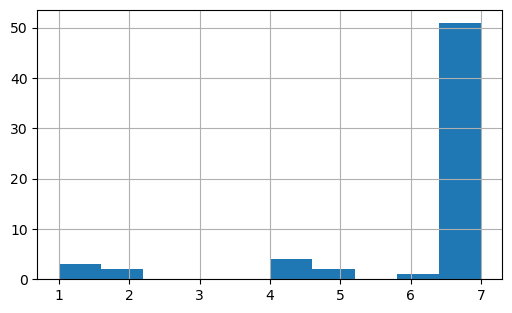

In [101]:
data_recall.DumbTo.hist(figsize=(6,3.5))
plt.show()

In [102]:
seq_length = sub_DumbTo.groupby("Subject_ID").size().reset_index()
seq_length.columns = ["Subject_ID", "Length"]
num_of_subjects = seq_length.shape[0]
print("Number of subjects:", num_of_subjects)

print("Min sequence lengh: ",seq_length.Length.min())

Number of subjects: 45
Min sequence lengh:  9676


In [103]:
# remove user 344 from seq-length and data (length is outlier)
seq_length = seq_length[seq_length.Subject_ID != 344]
sub_DumbTo = sub_DumbTo[sub_DumbTo.Subject_ID != 344]

In [104]:
num_of_subjects = seq_length.shape[0]
print("Number of subjects:", num_of_subjects)

Number of subjects: 44


In [105]:
cut_off = seq_length.Length.min()
print("Cutoff is :", cut_off)

Cutoff is : 9744


In [106]:
seq_length['Sum_Length'] = seq_length.Length.cumsum() 
seq_length = seq_length.reset_index()

# Adjust the length of all seqs
cut_off = seq_length.Length.min()

rem_index = np.zeros(sub_DumbTo.shape[0])
rem_index[0 : cut_off] = 1  
for i in range(0, seq_length.shape[0]-1):
    rem_index[seq_length.Sum_Length[i] : seq_length.Sum_Length[i]  + cut_off] = 1
    
sub_DumbTo["Rem_Index"] = rem_index

sub_DumbTo = sub_DumbTo[sub_DumbTo.Rem_Index == 1]

print("Sqeuence length after adjustment:", sub_DumbTo.shape[0]/44)

sub_DumbTo = sub_DumbTo[related_features]

Sqeuence length after adjustment: 9744.0


In [107]:
num_non_zero_nulls_in_cols = sub_DumbTo.isnull().sum().reset_index()
num_non_zero_nulls_in_cols.columns = ["Column", "Num_Nulls"]
num_non_zero_nulls_in_cols = num_non_zero_nulls_in_cols[num_non_zero_nulls_in_cols.Num_Nulls != 0]

In [108]:
# In the data one user has no value for the above columns and the first value of all users is null
num_non_zero_nulls_in_cols

,Column,Num_Nulls
8,Normed_LPS,9787
12,Normed_RPS,9787


In [109]:
# remove user 345 from seq-length and data (has missing values for 4 columns)
seq_length = seq_length[seq_length.Subject_ID != 345]
sub_DumbTo = sub_DumbTo[~sub_DumbTo.Normed_LPS.isna()]
# We can remove all nulls and make the sequnce one unit smaller
#sub_DumbTo = sub_DumbTo.dropna()

# For the above four columns the first element of each sequence was na, so the sequence length (cut_off) is reduced by 1
cut_off = cut_off - 1
num_of_subjects = sub_DumbTo.shape[0]/(cut_off)
print("Sequence length (cutt_off) equls: ", cut_off)
print("Number of Subjects is: ", int(num_of_subjects))

sub_DumbTo = sub_DumbTo.drop(columns=['Subject_ID'])

Sequence length (cutt_off) equls:  9743
Number of Subjects is:  43


In [110]:
num_non_zero_nulls_in_cols = sub_DumbTo.isnull().sum().reset_index()
num_non_zero_nulls_in_cols.columns = ["Column", "Num_Nulls"]
num_non_zero_nulls_in_cols = num_non_zero_nulls_in_cols[num_non_zero_nulls_in_cols.Num_Nulls != 0]

In [111]:
num_non_zero_nulls_in_cols

,Column,Num_Nulls


In [112]:
# One participants had null values for the last four variables we drop that, so we reduce one from seq_length.shape[0]
# we dropped subject_id from related features so we have len(related_features) -1 in reshape dimmentions
x = sub_DumbTo.to_numpy()
x = x.reshape(int(num_of_subjects), -1, len(related_features) -1 )

In [113]:
print("x.shape: ", x.shape)

x.shape:  (43, 9743, 25)


In [114]:
y = []
for subject_id in seq_length.Subject_ID:
    y.append(data_recall[data_recall.ExternalReference == subject_id].DumbTo.tolist()[0])
y = np.array(y)
print('len(y):', len(y))

len(y): 43


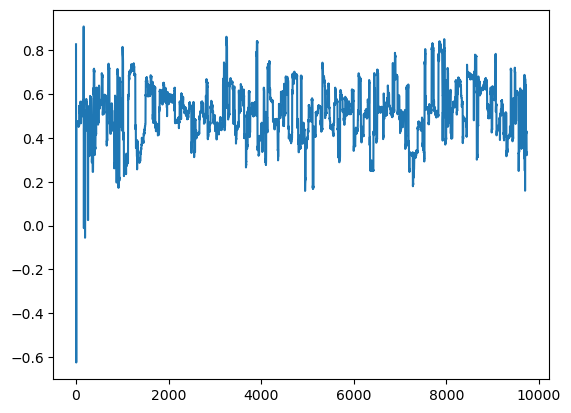

In [115]:
plt.plot(x[3][:, 2])
plt.show()

## Modeling

In [116]:
x_train = x[:37]
y_train = y[:37]
x_valid = x[37:]
y_valid = y[37:]

In [117]:
special_value = -9999.99
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen = cut_off, padding = "post", dtype = 'float64', value = special_value)
x_valid = keras.preprocessing.sequence.pad_sequences(x_valid, maxlen = cut_off, padding = "post", dtype = 'float64', value = special_value)

print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

(37, 9743, 25)
(37,)
(6, 9743, 25)
(6,)


In [118]:
nan_count_df = pd.DataFrame(columns = related_features[1:])

In [119]:
nan_count_df

,FPOGX,FPOGY,BPOGX,BPOGY,LPCX,LPCY,Normed_LPD,Normed_LPS,RPCX,RPCY,...,Contempt_Evidence,Disgust_Evidence,Joy_Evidence,Fear_Evidence,Negative_Evidence,Neutral_Evidence,Positive_Evidence,Sadness_Evidence,Surprise_Evidence,Heart_Rate


In [120]:
for i in range(x.shape[0]):
    nan_count_df.loc[len(nan_count_df)] = sum(np.isnan(x[i]), 0)

In [121]:
df_nan_ratio = (nan_count_df[['FPOGX', 'FPOGY', 'BPOGX', 'BPOGY', 
       'LPCX', 'LPCY', 'Normed_LPD', 'Normed_LPS', 'RPCX', 'RPCY', 'Normed_RPD', 'Normed_RPS', 
       'LPUPILD', 'RPUPILD']]/cut_off) 

In [122]:
np.round(df_nan_ratio, decimals = 1)

,FPOGX,FPOGY,BPOGX,BPOGY,LPCX,LPCY,Normed_LPD,Normed_LPS,RPCX,RPCY,Normed_RPD,Normed_RPS,LPUPILD,RPUPILD
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


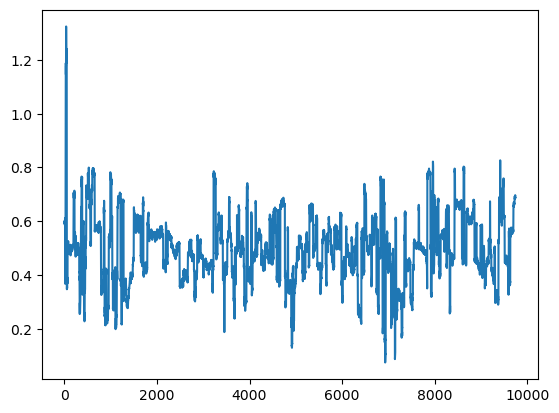

In [123]:
plt.plot(x[7][:, 2])
plt.show()

In [124]:
x.shape

(43, 9743, 25)

In [125]:
model = keras.Sequential()
model.add(keras.layers.Masking(mask_value=special_value, input_shape=(cut_off, len(related_features) -1)))
model.add(keras.layers.LSTM(32))
model.add(keras.layers.Dense(1))

model.compile(loss = keras.losses.MeanSquaredError(),
              optimizer = keras.optimizers.Adam(learning_rate=0.01))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 9743, 25)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                7424      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 7,457
Trainable params: 7,457
Non-trainable params: 0
_________________________________________________________________


In [126]:
history = model.fit(x = x_train, y = y_train, 
                    validation_data = (x_valid, y_valid),
                    epochs = 25)

Epoch 1/25
2/2 [==============================] - 4s 2s/step - loss: 39.2108 - val_loss: 27.1760
Epoch 2/25
2/2 [==============================] - 3s 2s/step - loss: 33.7620 - val_loss: 21.7785
Epoch 3/25
2/2 [==============================] - 3s 1s/step - loss: 27.7794 - val_loss: 17.7714
Epoch 4/25
2/2 [==============================] - 3s 2s/step - loss: 23.1727 - val_loss: 13.9761
Epoch 5/25
2/2 [==============================] - 3s 1s/step - loss: 18.9076 - val_loss: 10.5238
Epoch 6/25
2/2 [==============================] - 3s 1s/step - loss: 14.5754 - val_loss: 6.7013
Epoch 7/25
2/2 [==============================] - 3s 1s/step - loss: 9.6560 - val_loss: 3.9575
Epoch 8/25
2/2 [==============================] - 3s 1s/step - loss: 5.4591 - val_loss: 2.6979
Epoch 9/25
2/2 [==============================] - 3s 2s/step - loss: 2.5562 - val_loss: 2.8981
Epoch 10/25
2/2 [==============================] - 3s 2s/step - loss: 1.1346 - val_loss: 4.2587
Epoch 11/25
2/2 [=====================

In [127]:
y_df = pd.DataFrame(y)
y_df.columns = ['Cont']
y_df["Dis"] = 1
y_df.loc[y_df.Cont > 5, "Dis"] = 2
y_df.loc[y_df.Cont < 3, "Dis"] = 0

In [128]:
y_df.head()

,Cont,Dis
0,7.0,2
1,7.0,2
2,2.0,0
3,7.0,2
4,7.0,2


In [129]:
y = np.array(y_df.Dis)
y_train = y[:37]
y_valid = y[37:]

In [130]:
model = keras.Sequential()
model.add(keras.layers.Masking(mask_value=special_value, input_shape=(cut_off, len(related_features) -1)))
model.add(keras.layers.LSTM(32))
model.add(keras.layers.Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])

In [131]:
history = model.fit(x = x_train, y = y_train, 
                    validation_data = (x_valid, y_valid),
                    epochs = 10)

Epoch 1/10
2/2 [==============================] - 4s 2s/step - loss: 0.5424 - accuracy: 0.8919 - val_loss: 0.9226 - val_accuracy: 0.6667
Epoch 2/10
2/2 [==============================] - 3s 2s/step - loss: 0.4286 - accuracy: 0.8919 - val_loss: 1.0461 - val_accuracy: 0.6667
Epoch 3/10
2/2 [==============================] - 3s 2s/step - loss: 0.3988 - accuracy: 0.8919 - val_loss: 1.1517 - val_accuracy: 0.6667
Epoch 4/10
2/2 [==============================] - 3s 2s/step - loss: 0.3845 - accuracy: 0.8919 - val_loss: 1.2053 - val_accuracy: 0.6667
Epoch 5/10
2/2 [==============================] - 4s 2s/step - loss: 0.3773 - accuracy: 0.8919 - val_loss: 1.2267 - val_accuracy: 0.6667
Epoch 6/10
2/2 [==============================] - 4s 2s/step - loss: 0.3748 - accuracy: 0.8919 - val_loss: 1.2475 - val_accuracy: 0.6667
Epoch 7/10
2/2 [==============================] - 4s 2s/step - loss: 0.3664 - accuracy: 0.8919 - val_loss: 1.2577 - val_accuracy: 0.6667
Epoch 8/10
2/2 [=========================

In [ ]:
y_score = model.predict(x_valid)
y_score

In [ ]:
y_valid

In [ ]:
feature_idx = 15

In [ ]:
plt.style.use('classic')
fig, ax = plt.subplots()

In [ ]:
plt.plot(x_valid[0][:,feature_idx])
plt.plot(x_valid[1][:,feature_idx])
plt.plot(x_valid[2][:,feature_idx])
plt.plot(x_valid[3][:,feature_idx])
plt.plot(x_valid[4][:,feature_idx])
plt.plot(x_valid[5][:,feature_idx])
plt.show()

In [ ]:
plt.plot(x_valid[2][:,feature_idx])
plt.plot(x_valid[4][:,feature_idx])
plt.plot(x_valid[5][:,feature_idx])
plt.show()

In [ ]:
y_dis_pred_valid

In [ ]:
y_dis_train = tf.keras.utils.to_categorical(y_dis_train, num_classes=3)
y_dis_valid = tf.keras.utils.to_categorical(y_dis_valid, num_classes=3)

In [ ]:
y_dis_valid

In [ ]:
n_classes = 3
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_dis_valid[:, i],
                                                        y_dis_pred_valid[:, i])
    average_precision[i] = average_precision_score(y_dis_valid[:, i], y_dis_pred_valid[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_dis_valid.ravel(),
     y_dis_pred_valid.ravel())
average_precision["micro"] = average_precision_score(y_dis_valid,  y_dis_pred_valid,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

## Sklearn Example for Percision Recall Curve
[link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)

In [ ]:

# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()


In [ ]:
y_dis_pred_valid

In [ ]:
y_pred_naive = np.full(y_dis_valid.shape, 2)
accuracy_score(y_dis_valid, y_pred_naive)

In [ ]:
y_dis_valid

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Masking(mask_value=special_value, input_shape=(cut_off, len(related_features) -1)))
model.add(keras.layers.LSTM(32))
model.add(keras.layers.Dense(3, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])

In [ ]:
history = model.fit(x = x_train, y = y_dis_train, 
                    validation_data = (x_valid, y_dis_valid),
                    epochs = 25)

In [ ]:
y_dis_valid

In [ ]:
y_dis_train